In [4]:
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Load dataset
df = pd.read_csv("/content/employee_data.csv")

# Handle missing values
df["filed_complaint"].fillna(0, inplace=True)
df["recently_promoted"].fillna(0, inplace=True)
df["last_evaluation"].fillna(df["last_evaluation"].median(), inplace=True)
df["satisfaction"].fillna(df["satisfaction"].median(), inplace=True)
df["tenure"].fillna(df["tenure"].median(), inplace=True)
df.dropna(subset=["department"], inplace=True)

# Encode categorical variables
label_enc = LabelEncoder()
df["salary"] = label_enc.fit_transform(df["salary"])
df["department"] = label_enc.fit_transform(df["department"])
df["status"] = df["status"].map({"Left": 1, "Employed": 0})  # Target variable

# Feature Scaling
scaler = MinMaxScaler()
features = ["avg_monthly_hrs", "department", "filed_complaint", "last_evaluation",
            "n_projects", "recently_promoted", "salary", "satisfaction", "tenure"]
df[features] = scaler.fit_transform(df[features])

# Split dataset
X = df[features]
y = df["status"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(df.head())  # Display sample data


   avg_monthly_hrs  department  filed_complaint  last_evaluation  n_projects  \
0         0.659004    0.181818              0.0         0.901828    0.500000   
1         0.701149    0.909091              0.0         0.597761    0.333333   
2         0.517241    0.818182              0.0         0.691193    0.333333   
3         0.601533    0.818182              0.0         0.379502    0.500000   
4         0.766284    0.818182              0.0         0.773652    0.333333   

   recently_promoted  salary  satisfaction  status  tenure  
0                0.0     0.5      0.822798       1   0.375  
1                0.0     0.5      0.827639       0   0.000  
2                0.0     1.0      0.828102       0   0.125  
3                0.0     0.5      0.400760       0   0.000  
4                0.0     0.5      0.769823       0   0.125  


In [5]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SelectFromModel

# Ridge Regression for Feature Selection
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train, y_train)

# Set a lower threshold to select more features
threshold_value = np.percentile(np.abs(ridge.coef_), 30)  # Adjust this value to control selection

# Select features based on threshold
selector = SelectFromModel(ridge, threshold=threshold_value, prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Get selected feature names
selected_features = np.array(X_train.columns)[selector.get_support()]
print("\nSelected Features:", list(selected_features))



Selected Features: ['avg_monthly_hrs', 'filed_complaint', 'n_projects', 'recently_promoted', 'satisfaction', 'tenure']


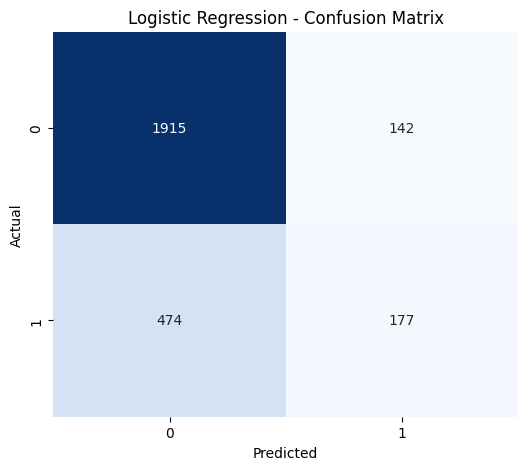


Logistic Regression - Accuracy: 0.77
Confusion Matrix:
[[1915  142]
 [ 474  177]]


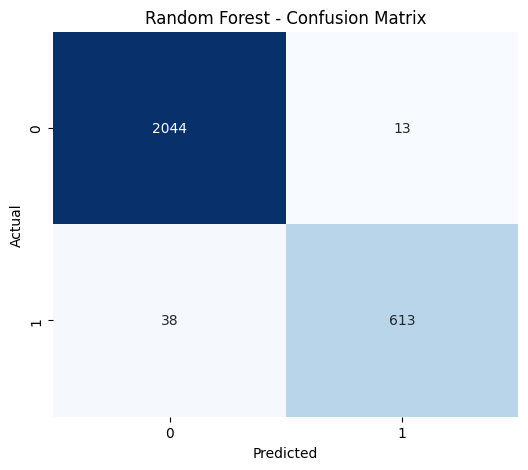


Random Forest - Accuracy: 0.98
Confusion Matrix:
[[2044   13]
 [  38  613]]


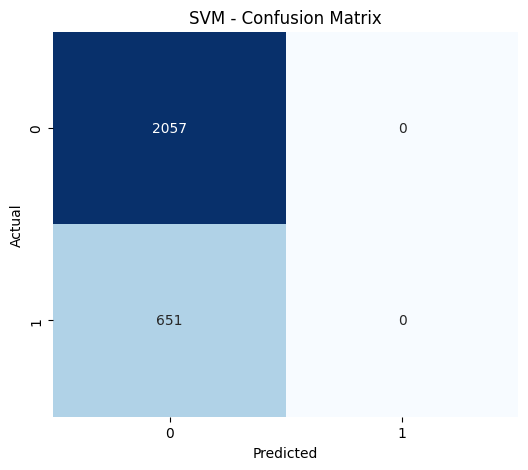


SVM - Accuracy: 0.76
Confusion Matrix:
[[2057    0]
 [ 651    0]]


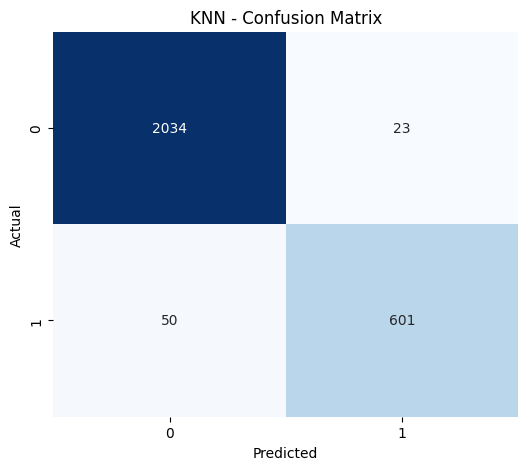


KNN - Accuracy: 0.97
Confusion Matrix:
[[2034   23]
 [  50  601]]


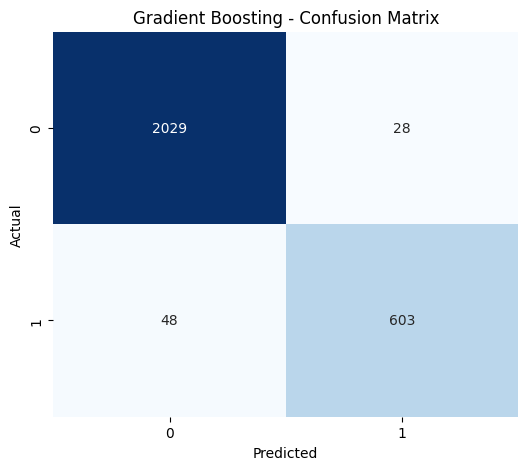


Gradient Boosting - Accuracy: 0.97
Confusion Matrix:
[[2029   28]
 [  48  603]]


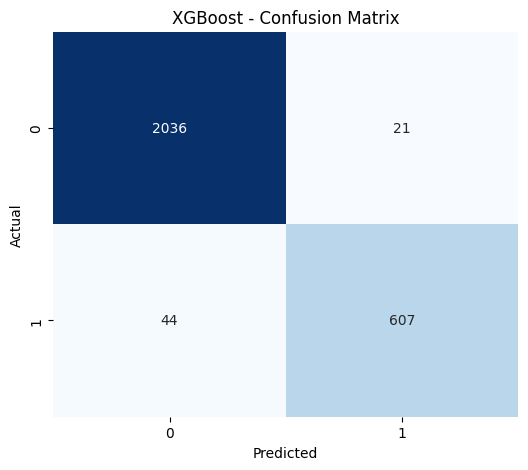


XGBoost - Accuracy: 0.98
Confusion Matrix:
[[2036   21]
 [  44  607]]


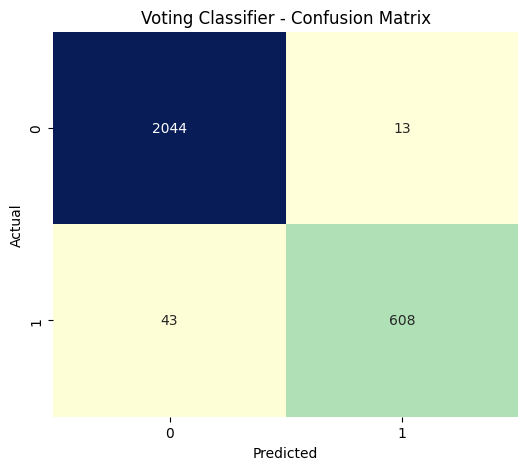


Voting Classifier - Accuracy: 0.98
Confusion Matrix:
[[2044   13]
 [  43  608]]


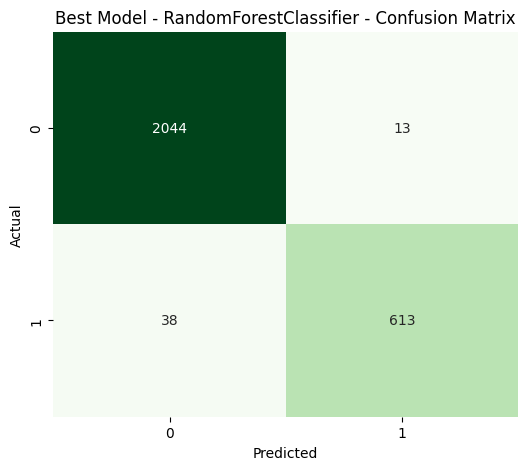


Best Model: RandomForestClassifier with accuracy: 0.98


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='linear'),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

best_model = None
best_accuracy = 0
results = {}

# Train and Evaluate Each Model
for name, model in models.items():
    if name == "XGBoost":  # Apply LabelEncoder only for XGBoost
        le = LabelEncoder()
        y_train_encoded = le.fit_transform(y_train)
        model.fit(X_train_selected, y_train_encoded)
        y_pred = model.predict(X_test_selected)
        y_pred = le.inverse_transform(y_pred)
    else:
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)

    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Print Performance Metrics
    print(f"\n{name} - Accuracy: {accuracy:.2f}")
    print(f"Confusion Matrix:\n{cm}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model

# Voting Classifier with Top 3 Models
top_models = sorted(results, key=results.get, reverse=True)[:3]
voting_clf = VotingClassifier(
    estimators=[(name, models[name]) for name in top_models],
    voting='hard'
)

# Train Voting Classifier
voting_clf.fit(X_train_selected, y_train)
y_pred_voting = voting_clf.predict(X_test_selected)
voting_accuracy = accuracy_score(y_test, y_pred_voting)

# Voting Classifier Confusion Matrix
cm_voting = confusion_matrix(y_test, y_pred_voting)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_voting, annot=True, fmt='g', cmap='YlGnBu', cbar=False)
plt.title(f"Voting Classifier - Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print Voting Classifier Performance
print(f"\nVoting Classifier - Accuracy: {voting_accuracy:.2f}")
print(f"Confusion Matrix:\n{cm_voting}")

# Select Best Model
if voting_accuracy > best_accuracy:
    best_model = voting_clf
    best_accuracy = voting_accuracy

# Best Model Confusion Matrix with Different Colour
cm_best = confusion_matrix(y_test, best_model.predict(X_test_selected))
plt.figure(figsize=(6, 5))
sns.heatmap(cm_best, annot=True, fmt='g', cmap='Greens', cbar=False)
plt.title(f"Best Model - {best_model.__class__.__name__} - Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print Best Model
print(f"\nBest Model: {best_model.__class__.__name__} with accuracy: {best_accuracy:.2f}")


In [10]:
import pandas as pd

# Predict attrition for all employees
y_pred_best = best_model.predict(X_test_selected)

# Convert predictions into a DataFrame
results_df = pd.DataFrame({
    "Employee_ID": range(1, len(y_pred_best) + 1),  # Assign employee IDs
    "Predicted_Attrition": y_pred_best
})

# Define All Retention Strategies
leaving_strategies = """- Offer skill development programs
- Provide flexible work arrangements
- Increase salary and benefits
- Assign challenging and meaningful work
- Improve company culture and communication
- Offer leadership and mentorship programs
- Recognize and reward contributions
- Conduct stay interviews to understand concerns"""

staying_strategies = """- Continue professional growth opportunities
- Strengthen peer collaboration and team bonding
- Encourage innovation and idea-sharing
- Provide occasional bonuses and rewards
- Maintain work-life balance policies
- Celebrate employee achievements regularly"""

# Define Retention Strategies Function
def suggest_retention_strategy(prediction):
    return leaving_strategies if prediction == 1 else staying_strategies

# Apply strategies
results_df["Retention_Strategy"] = results_df["Predicted_Attrition"].apply(suggest_retention_strategy)

# Print suggestions for the first 100 employees with separate lines
for i in range(50):
    print(f"Employee ID: {results_df.loc[i, 'Employee_ID']}")
    print(f"Predicted Attrition: {'Leaving' if results_df.loc[i, 'Predicted_Attrition'] == 1 else 'Staying'}")
    print("Retention Strategy:")
    print(results_df.loc[i, "Retention_Strategy"])
    print("-" * 50)  # Separator for readability


Employee ID: 1
Predicted Attrition: Staying
Retention Strategy:
- Continue professional growth opportunities
- Strengthen peer collaboration and team bonding
- Encourage innovation and idea-sharing
- Provide occasional bonuses and rewards
- Maintain work-life balance policies
- Celebrate employee achievements regularly
--------------------------------------------------
Employee ID: 2
Predicted Attrition: Staying
Retention Strategy:
- Continue professional growth opportunities
- Strengthen peer collaboration and team bonding
- Encourage innovation and idea-sharing
- Provide occasional bonuses and rewards
- Maintain work-life balance policies
- Celebrate employee achievements regularly
--------------------------------------------------
Employee ID: 3
Predicted Attrition: Staying
Retention Strategy:
- Continue professional growth opportunities
- Strengthen peer collaboration and team bonding
- Encourage innovation and idea-sharing
- Provide occasional bonuses and rewards
- Maintain work-l